# Zaitsev Anton | Exercise 10

## General Information

In this exercise we will try to predict links based on edge embeddings in the Facebook graph (**Group 8**). We will first randomly delete 10% of the edges in the network, train a ML model on the edge embeddings of the available edges and then try to reconstruct the deleted 10% of the edges.

Our pipeline for the link prediction is the same as in the previous exercise 9, but instead of manually computing the feature vectors for the edges, we will use Node2Vec algorithm.

## Imports

In [1]:
!pip install xgboost
!pip install node2vec

   ---------------------------------------- 0.0/24.0 MB ? eta -:--:--
   --- ------------------------------------ 2.1/24.0 MB 10.7 MB/s eta 0:00:03
   ------- -------------------------------- 4.7/24.0 MB 11.4 MB/s eta 0:00:02
   ------------ --------------------------- 7.3/24.0 MB 11.6 MB/s eta 0:00:02
   ---------------- ----------------------- 9.7/24.0 MB 11.6 MB/s eta 0:00:02
   ------------------ --------------------- 11.3/24.0 MB 11.6 MB/s eta 0:00:02
   --------------------- ------------------ 12.8/24.0 MB 10.1 MB/s eta 0:00:02
   ------------------------- -------------- 15.2/24.0 MB 10.3 MB/s eta 0:00:01
   ----------------------------- ---------- 17.8/24.0 MB 10.5 MB/s eta 0:00:01
   --------------------------------- ------ 20.2/24.0 MB 10.6 MB/s eta 0:00:01
   ------------------------------------ --- 21.8/24.0 MB 10.3 MB/s eta 0:00:01
   ---------------------------------------  23.9/24.0 MB 10.8 MB/s eta 0:00:01
   ---------------------------------------- 24.0/24.0 MB 9.4 MB/s

In [ ]:
import networkx as nx
import numpy as np
import random
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.decomposition import PCA

from node2vec import Node2Vec
from node2vec.edges import HadamardEmbedder

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, precision_score, accuracy_score, roc_curve

In [3]:
random.seed(1)

## Global Variables

In [4]:
DATA_FOLDER = "../data/"

## Link Prediction Pipeline

### 1. Load Graph

In [5]:
def constructGraph(edges_path: str, directed: bool = False) -> nx.Graph:
    """
    Construct a graph from an edge list.

    Parameters:
        - edges_path (str): The path to the .edges file, which contains the edges of the graph.
        - directed (bool): If True, the graph will be treated as directed, creating a NetworkX DiGraph.
    
    Returns:
        - g (nx.Graph or nx.DiGraph): A NetworkX graph containing all the nodes and edges from the .edges file.
                                      Additionally, nodes present in the .feat file but missing in the .edges
                                      file will be added to the graph as disconnected nodes (without any edges).
    """
    # read graph from .edges file
    if directed:
        g = nx.read_edgelist(edges_path, create_using=nx.DiGraph(), nodetype=int)
    else:
        g = nx.read_edgelist(edges_path, create_using=nx.Graph(), nodetype=int)
    return g

In [6]:
# load facebook network, indirected graph
G_fb = constructGraph(edges_path=f"{DATA_FOLDER}3437.edges", directed=False)
G = G_fb.copy()

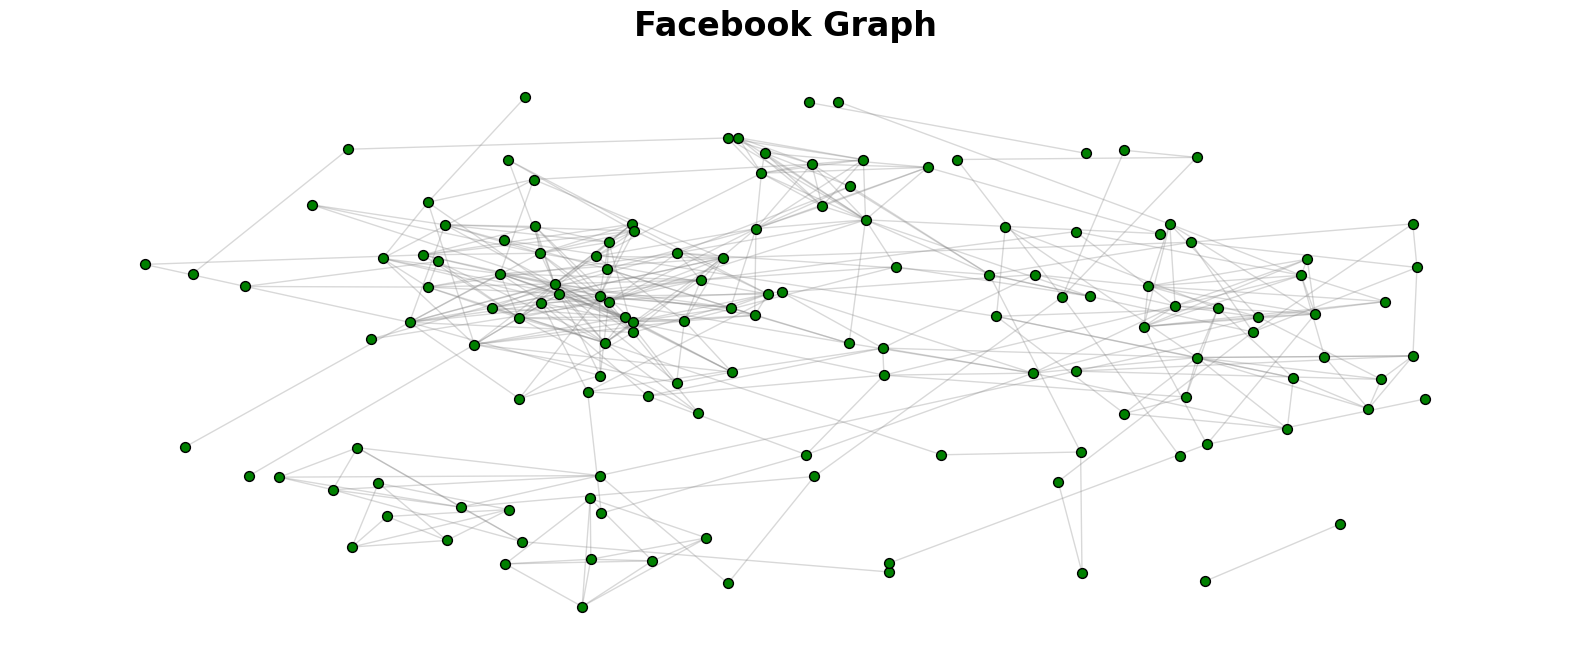

In [7]:
# plot G_fb
plt.figure(figsize=(20, 8))
pos = nx.spring_layout(G_fb, k=0.4)
nx.draw_networkx_nodes(G_fb, pos, node_color="green", node_size=50, edgecolors="black", linewidths=1)
nx.draw_networkx_edges(G_fb, pos, edge_color="gray", alpha=0.3)
plt.title("Facebook Graph", fontsize=24, fontweight="bold")
plt.axis('off')
plt.show()

### 2. Define Positive/Negative Edges

In [8]:
# get all positive (existing) edges
positive_edges = list(G.edges())
# generate negative (non-existent) edges
non_edges = list(nx.non_edges(G))
random.shuffle(non_edges)
negative_edges = non_edges
# combine positive and negative edges
all_edges = positive_edges + negative_edges
# define binary labels for each edge
labels = np.hstack([np.ones(len(positive_edges)), np.zeros(len(negative_edges))])

print(f"Number of positive edges: {len(positive_edges)}")
print(f"Number of negative edges: {len(negative_edges)}")
print(f"Random positive edge: {all_edges[0]}")
print(f"Random negative edge: {all_edges[-1]}")
print(f"Labels peek: {labels[:5], labels[-5:]}")


Number of positive edges: 407
Number of negative edges: 9323
Random positive edge: (3562, 3479)
Random negative edge: (3452, 3523)
Labels peek: (array([1., 1., 1., 1., 1.]), array([0., 0., 0., 0., 0.]))


### 3. Embed Edges using Node2Vec and Hadamard Product

In [11]:
# train Node2Vec model: precompute probabilities and generate walks
node2vec = Node2Vec(G, dimensions=128, walk_length=30, num_walks=200, workers=1)
model = node2vec.fit(window=10, min_count=1, batch_words=4)
# embed edges using Hadamard method
hadamard_embedder = HadamardEmbedder(keyed_vectors=model.wv)
edge_features = np.array([hadamard_embedder[(str(edge[0]), str(edge[1]))] for edge in all_edges])

Computing transition probabilities:   0%|          | 0/140 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 200/200 [00:02<00:00, 68.23it/s]


In [13]:
print(f"Length of an embedding of a positive edge {all_edges[10]}: {len(edge_features[10])}")
print(f"Length of an embedding of a negative edge {all_edges[-10]}: {len(edge_features[-10])}")

Length of an embedding of a positive edge (3517, 3438): 128
Length of an embedding of a negative edge (3445, 3580): 128


Let's plot each embedding for positive and negative edges. Note that embeddings have 128 dimensionality, so we reduce it to 2 using PCA.

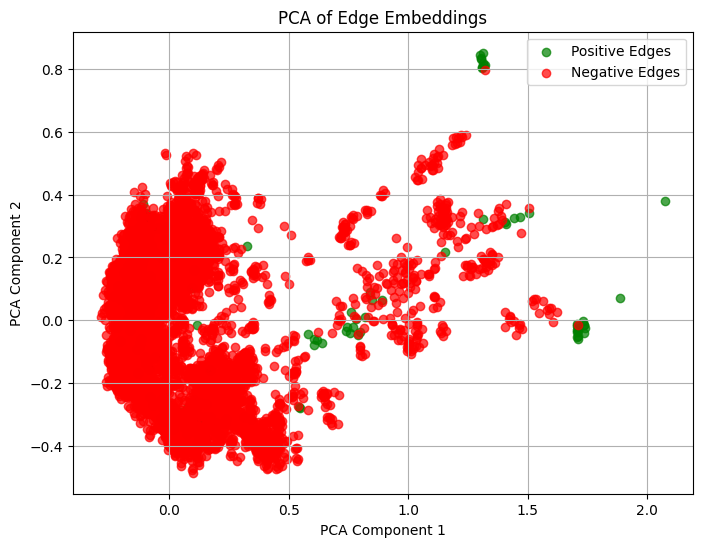

In [17]:
# PCA to reduce dimensionality to 2
pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(edge_features)

positive_embeddings = reduced_embeddings[:len(positive_edges)]
negative_embeddings = reduced_embeddings[len(positive_edges):]
plt.figure(figsize=(8, 6))
plt.scatter(
    positive_embeddings[:, 0], positive_embeddings[:, 1], 
    c="green", label="Positive Edges", alpha=0.7
)
plt.scatter(
    negative_embeddings[:, 0], negative_embeddings[:, 1], 
    c="red", label="Negative Edges", alpha=0.7
)
plt.title("PCA of Edge Embeddings")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend()
plt.grid(True)
plt.show()

We see a clear difference between the features of existing and non-existent edges.

### 4. Split Data into Train/Test (10%) Sets

Now we split our data into train and test sets. Basically, the idea is as follows: we train the model on the train set, which includes existing and non-existing edges. Then, we evaluate our model on the remaining edges, which include 10% of the existing edges and 10% of non-existing edges.

In [18]:
original_indices = np.arange(len(all_edges))
X_train, X_test, y_train, y_test, train_indices, test_indices = train_test_split(
    edge_features, labels, original_indices, test_size=0.1, stratify=labels, random_state=1
)

### 5. Train Random Forest and LightGBM using Best Parameters from Exercise 9

In [ ]:
# class weights for xgb (due to imbalanced data)
scale_pos_weight = len(y_train[y_train == 0]) / len(y_train[y_train == 1])

#### Retrieve Best Models

- Best parameters for Random Forest:
```
{'classifier__bootstrap': True, 'classifier__max_depth': None, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 64}
```

- Best parameters for XGBoost:
```
{'classifier__colsample_bytree': 0.8, 'classifier__learning_rate': 0.01, 'classifier__max_depth': 2, 'classifier__n_estimators': 64, 'classifier__subsample': 0.8}
```

In [22]:
# retrieve the best Random Forest pipeline
best_rf_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("classifier", RandomForestClassifier(
        **{
            'bootstrap': True,
            'max_depth': None,
            'min_samples_leaf': 1,
            'min_samples_split': 2,
            'n_estimators': 64,
            'class_weight': "balanced",
            'random_state': 1
        }
    ))
])
# fit
best_rf_pipeline.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('classifier',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=64, random_state=1))])

In [23]:
# retrieve the best XGBoost pipeline
best_xgb_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("classifier", xgb.XGBClassifier(
        **{
            'objective': "binary:logistic",
            'scale_pos_weight': scale_pos_weight,
            'eval_metric': "logloss",
            'random_state': 1,
            'colsample_bytree': 0.8,
            'learning_rate': 0.01,
            'max_depth': 2,
            'n_estimators': 64,
            'subsample': 0.8
        }
    ))
])
# fit
best_xgb_pipeline.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('classifier',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.8, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric='logloss',
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.01,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=2, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=64, n_jobs=None,
                               num_parallel_tree=None, random_state=1, ...))])

### 6. Ensemble Link Prediction & Evaluation

In [24]:
# predict probabilities of existing links in the test set
rf_probs = best_rf_pipeline.predict_proba(X_test)[:, 1]
xgb_probs = best_xgb_pipeline.predict_proba(X_test)[:, 1]
# ensemble the probabilities using average
ensemble_probs = (rf_probs + xgb_probs) / 2
# convert probabilities to binary classes
ensemble_preds = (ensemble_probs >= 0.5).astype(int)


Ensemble Model Test Results:
Accuracy: 0.9743
AUROC: 0.9819
Precision: 0.7353


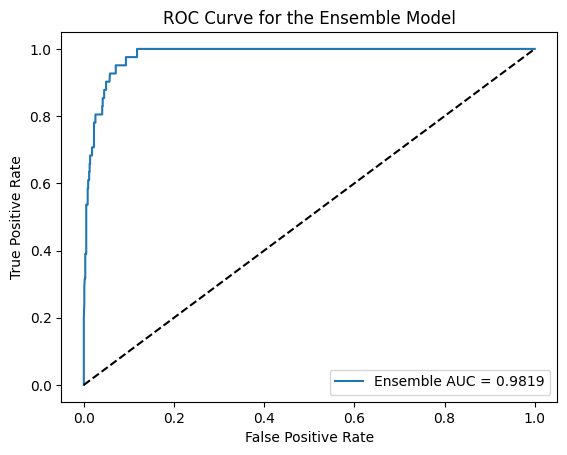

In [25]:
# calculate metrics
accuracy = accuracy_score(y_test, ensemble_preds)
auroc = roc_auc_score(y_test, ensemble_probs)
precision = precision_score(y_test, ensemble_preds, zero_division=0)

print("\nEnsemble Model Test Results:")
print(f"Accuracy: {accuracy:.4f}")
print(f"AUROC: {auroc:.4f}")
print(f"Precision: {precision:.4f}")

fpr, tpr, thresholds = roc_curve(y_test, ensemble_probs)

plt.figure()
plt.plot(fpr, tpr, label=f"Ensemble AUC = {auroc:.4f}")
plt.plot([0, 1], [0, 1], "k--")  # random predictions diagonal line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for the Ensemble Model")
plt.legend(loc="best")
plt.show()

Now we perform slightly different pipeline for edge prediction as we did in exercise 9.

In [26]:
# step 1: map positive test indices back to edges
positive_indecies_test = np.where(y_test == 1)[0]
positive_test_edge_indices = test_indices[positive_indecies_test] # original indices in all_edges
positive_test_edges = [all_edges[i] for i in positive_test_edge_indices]
# step 2: get all nodes in positive_test_edges
positive_test_nodes = set([node for edge in positive_test_edges for node in edge])
# step 3: find all possible edges between positive_test_nodes and all the nodes in G
all_nodes = list(G.nodes())
possible_edges = set()
for node1 in positive_test_nodes:
    for node2 in all_nodes:
        if node1 != node2:  # avoid self-loops
            possible_edges.add(tuple(sorted((node1, node2))))  # ensure undirected edges, avoid repetition
# step 4: remove edges that already exist in G
existing_edges = set(tuple(sorted(edge)) for edge in G.edges())  # ensure undirected edges, avoid repetition
negative_test_edges = list(possible_edges - existing_edges)

print("Positive Test Edges:", positive_test_edges)
print("Negative Test Edges:", negative_test_edges)

Positive Test Edges: [(3581, 3516), (3562, 3581), (3549, 3531), (3464, 3474), (3517, 3449), (3577, 3576), (3501, 3495), (3464, 3443), (3488, 3527), (3530, 3511), (862, 1085), (3521, 3484), (3523, 3516), (862, 698), (3545, 3450), (3519, 3571), (3521, 3482), (3501, 3438), (3551, 3496), (3529, 3568), (3510, 3464), (3552, 3573), (3506, 3458), (3509, 3569), (3454, 567), (3520, 3496), (3540, 1085), (3545, 3488), (3505, 3508), (3526, 3472), (3460, 3568), (3559, 3528), (3568, 3564), (3455, 3553), (3576, 3573), (3576, 3528), (3556, 1085), (3545, 3438), (3455, 3470), (3545, 3514), (3504, 3487)]
Negative Test Edges: [(3526, 3535), (3454, 3516), (3473, 3529), (3484, 3538), (3525, 3576), (3448, 3472), (3508, 3523), (3500, 3519), (3466, 3526), (3458, 3522), (3450, 3518), (3469, 3531), (3510, 3532), (3521, 3578), (3562, 3579), (1085, 3461), (862, 3532), (3511, 3533), (3443, 3478), (3530, 3546), (3503, 3529), (3514, 3538), (3472, 3541), (3438, 3548), (3455, 3488), (1085, 3582), (3454, 3529), (3506, 35

In [ ]:
# step 5: compute embeddings for all positive and negative edges for the nodes in the test set
positive_test_features = np.array([hadamard_embedder[(str(edge[0]), str(edge[1]))] for edge in positive_test_edges])
negative_test_features = np.array([hadamard_embedder[(str(edge[0]), str(edge[1]))] for edge in negative_test_edges])

In [28]:
# step 6: predict for positive edges
rf_probs_pos = best_rf_pipeline.predict_proba(positive_test_features)[:, 1]
xgb_probs_pos = best_xgb_pipeline.predict_proba(positive_test_features)[:, 1]
ensemble_probs_pos = (rf_probs_pos + xgb_probs_pos) / 2
ensemble_preds_pos = (ensemble_probs_pos >= 0.5).astype(int)
# step 7: predict for negative edges
rf_probs_neg = best_rf_pipeline.predict_proba(negative_test_features)[:, 1]
xgb_probs_neg = best_xgb_pipeline.predict_proba(negative_test_features)[:, 1]
ensemble_probs_neg = (rf_probs_neg + xgb_probs_neg) / 2
ensemble_preds_neg = (ensemble_probs_neg >= 0.5).astype(int)


Ensemble Model Test Results:
Accuracy: 0.9967
AUROC: 0.9898
Precision: 0.8333


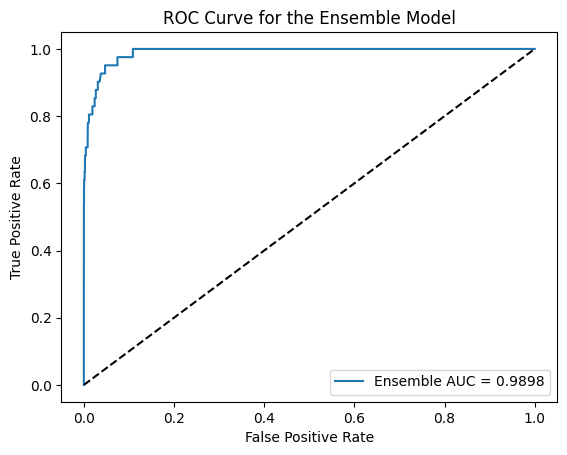

In [29]:
# step 8: compute metrics
ensemble_preds_pos_neg = np.concatenate([ensemble_preds_pos, ensemble_preds_neg]) # stack predictions, positive first
ensemble_probs_pos_neg = np.concatenate([ensemble_probs_pos, ensemble_probs_neg]) # stack prediction probabilities, positive first
y_test_pos_neg = np.concatenate([np.ones(len(ensemble_preds_pos)), np.zeros(len(ensemble_preds_neg))]) # 1s for positive edges, 0s for negative edges

accuracy = accuracy_score(y_test_pos_neg, ensemble_preds_pos_neg)
auroc = roc_auc_score(y_test_pos_neg, ensemble_probs_pos_neg)
precision = precision_score(y_test_pos_neg, ensemble_preds_pos_neg, zero_division=0)
print("\nEnsemble Model Test Results:")
print(f"Accuracy: {accuracy:.4f}")
print(f"AUROC: {auroc:.4f}")
print(f"Precision: {precision:.4f}")


fpr, tpr, thresholds = roc_curve(y_test_pos_neg, ensemble_probs_pos_neg)
plt.figure()
plt.plot(fpr, tpr, label=f"Ensemble AUC = {auroc:.4f}")
plt.plot([0, 1], [0, 1], "k--")  # random predictions diagonal line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for the Ensemble Model")
plt.legend(loc="best")
plt.show()
